In [5]:
from mm_sbi_review.examples.turin import turin, compute_turin_summaries
import torch
import numpy as np
from sbi.inference import NLE
from sbi.utils import BoxUniform
from mm_sbi_review.examples.turin import TurinSummary
import matplotlib.pyplot as plt
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

FileNotFoundError: [Errno 2] No such file or directory: 'plots/prior_predictive_checks_summary_0.pdf'

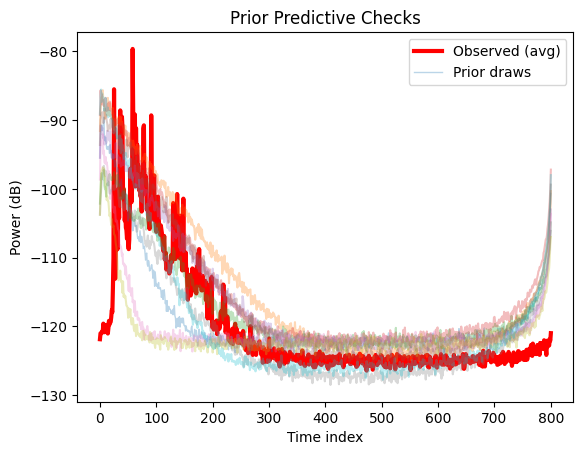

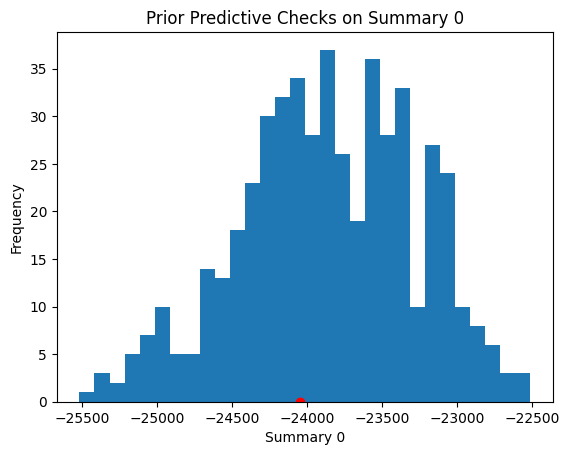

In [6]:
    N = 100
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    x_data_full = (
        torch.tensor(np.load("../data/turin_obs.npy")).float().reshape(N, 801).to(device)
    )
    B = 4e9
    Ns = 801
    x_obs = compute_turin_summaries(x_data_full, delta_f=(B / (Ns - 1)))
    turin_sim = turin(B=B, Ns=801, N=N, tau0=0)

    def simulator(thetas):
        num_sims = thetas.shape[0]
        x_data_full = torch.zeros(num_sims, N, 801)
        x_sim = torch.zeros(num_sims, 12)
        for i in range(num_sims):
            x_data_full = turin_sim(thetas[i, :])
            x_sim[i, :] = compute_turin_summaries(x_data_full, delta_f=(B / (Ns - 1)))
        # x_sim = torch.squeeze(x_sim)
        return x_sim

    # test_theta = torch.tensor([10 ** (-8.4), 7.8e-9, 1e9, 2.8e-10])
    # x_sim = simulator(test_theta)

    prior = BoxUniform(
        low=torch.tensor([1e-9, 1e-9, 1e7, 1e-10]),
        high=torch.tensor([1e-8, 1e-8, 5e9, 1e-9]),
    )
    check_sbi_inputs(simulator, prior)

    inference = NLE(prior)
    proposal = prior
    num_rounds = 5
    num_sims = 500

    # Prior predictive plots
    num_prior_sims = 10
    x_data_avg = torch.mean(x_data_full, dim=0)

    # Create a figure
    plt.figure()

    # Plot observed average
    plt.plot(x_data_avg.cpu().numpy(), color="red", linewidth=3, label="Observed (avg)")

    # Draw some samples from the prior and plot their simulated averages
    for i in range(num_prior_sims):
        theta = prior.sample((1,))
        x_prior_pred = turin_sim(theta)
        x_prior_pred_avg = torch.mean(x_prior_pred, dim=0)
        # Only add a legend label to the first prior draw, to avoid clutter
        if i == 0:
            plt.plot(
                x_prior_pred_avg.cpu().numpy(),
                linewidth=1,
                alpha=0.3,
                label="Prior draws",
            )
        else:
            plt.plot(x_prior_pred_avg.cpu().numpy(), alpha=0.3)

    # A few labels and legend
    plt.xlabel("Time index")
    plt.ylabel("Power (dB)")
    plt.title("Prior Predictive Checks")
    plt.legend()

    # Save the figure
    plt.savefig("../plots/prior_predictive_checks_full_data.pdf")

    # Do Prior predictive checks on summaries
    # bivariate plot of summaries
    num_prior_sims = 500
    prior_summs = torch.empty(num_prior_sims, 12)
    for i in range(num_prior_sims):
        theta = prior.sample((1,))
        x_prior_pred = turin_sim(theta)
        x_prior_summ = compute_turin_summaries(x_prior_pred, delta_f=(B / (Ns - 1)))
        prior_summs[i, :] = x_prior_summ
    # histogram plots
    for i in range(12):

        plt.figure()
        plt.hist(prior_summs[:, i].cpu().numpy(), bins=30)
        plt.plot(x_obs[i].cpu().numpy(), 0, "ro", label="Observed")
        plt.xlabel(f"Summary {i}")
        plt.ylabel("Frequency")
        plt.title(f"Prior Predictive Checks on Summary {i}")
        plt.savefig(f"plots/prior_predictive_checks_summary_{i}.pdf")

    # plot bivariate scatter plots
    for i in range(12):
        for j in range(i + 1, 12):
            plt.figure()
            plt.scatter(
                prior_summs[:, i].cpu().numpy(), prior_summs[:, j].cpu().numpy()
            )
            plt.plot(
                x_obs[i].cpu().numpy(), x_obs[j].cpu().numpy(), "ro", label="Observed"
            )
            plt.xlabel(f"Summary {i}")
            plt.ylabel(f"Summary {j}")
            plt.title(f"Prior Predictive Checks on Summary {i} vs Summary {j}")
            plt.savefig(f"../plots/prior_predictive_checks_summary_{i}_vs_summary_{j}.pdf")